In [151]:
#%matplotlib inline

import torch
import random


import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [152]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Thiết bị sử dụng: {device}")

Thiết bị sử dụng: cpu


In [153]:
BATCH_SIZE = 128
LATENT_DIM = 100
LEARNING_RATE = 0.0001
NUM_EPOCHS = 20


In [154]:
df = pd.read_csv('all_landmarks.csv')
df.head()

,label,frame,x0,y0,x1,y1,x2,y2,x3,y3,...,x16,y16,x17,y17,x18,y18,x19,y19,x20,y20
0,thumb,0,0.599915,0.665262,0.515953,0.665098,0.428840,0.633735,0.373814,0.601213,...,0.564590,0.550839,0.594947,0.469473,0.579057,0.432039,0.587348,0.481080,0.593778,0.516935
1,thumb,1,0.603023,0.697286,0.507298,0.672530,0.430429,0.638797,0.374489,0.601450,...,0.563151,0.544787,0.603814,0.477666,0.586528,0.427248,0.588528,0.476918,0.594982,0.515491
2,thumb,2,0.578484,0.664635,0.484652,0.639102,0.405413,0.603161,0.334007,0.565351,...,0.531455,0.492580,0.565373,0.441291,0.561908,0.379894,0.566244,0.439990,0.565475,0.475714
3,thumb,3,0.581487,0.675659,0.482386,0.638060,0.405132,0.608401,0.334031,0.565769,...,0.531379,0.501897,0.565993,0.438266,0.559864,0.379514,0.561746,0.442510,0.562781,0.481083
4,thumb,4,0.551713,0.643821,0.452903,0.613882,0.370420,0.581506,0.294350,0.545547,...,0.499876,0.477000,0.539230,0.416825,0.530130,0.364053,0.533174,0.430488,0.532756,0.462243


In [155]:
df = df.drop(columns=['frame'])
df.columns

Index(['label', 'x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4',
       'x5', 'y5', 'x6', 'y6', 'x7', 'y7', 'x8', 'y8', 'x9', 'y9', 'x10',
       'y10', 'x11', 'y11', 'x12', 'y12', 'x13', 'y13', 'x14', 'y14', 'x15',
       'y15', 'x16', 'y16', 'x17', 'y17', 'x18', 'y18', 'x19', 'y19', 'x20',
       'y20'],
      dtype='object')

In [156]:
NUM_CLASSES = df['label'].nunique()
print(f"Số lượng lớp (nhãn dán): {NUM_CLASSES}")

Số lượng lớp (nhãn dán): 2


In [157]:
class CoordinateDataset(Dataset):
    def __init__(self, df):
        """
        Khởi tạo dataset từ file CSV.
        Args:
            csv_file (str): Đường dẫn đến file CSV chứa tọa độ và nhãn dán.
        """
        self.data = df

        # Lấy nhãn dán
        self.labels = self.data['label'].values.reshape(-1, 1)

        # Sử dụng LabelEncoder và OneHotEncoder
        # 1. Label Encoding: Chuyển đổi nhãn chữ thành số
        le = LabelEncoder()
        integer_encoded = le.fit_transform(self.labels.ravel())

        # 2. One-Hot Encoding: Chuyển đổi số thành vector nhị phân
        onehot_encoder = OneHotEncoder(sparse_output=False)
        self.onehot_labels = onehot_encoder.fit_transform(integer_encoded.reshape(-1, 1))

        # Lưu thông tin về các nhãn
        self.num_classes = self.onehot_labels.shape[1]
        self.label_to_int = {label: i for i, label in enumerate(le.classes_)}
        self.int_to_label = {i: label for i, label in enumerate(le.classes_)}

        # Lấy dữ liệu tọa độ
        self.coordinates = self.data.drop('label', axis=1).values.astype(np.float32)

        # Lưu lại min/max của tọa độ để khôi phục sau này
        self.coordinates_min = self.coordinates.min(axis=0)
        self.coordinates_max = self.coordinates.max(axis=0)

        # Chuẩn hóa dữ liệu tọa độ về khoảng [-1, 1]
        self.coordinates = 2 * (self.coordinates - self.coordinates_min) / (self.coordinates_max - self.coordinates_min) - 1

    def __len__(self):
        """
        Trả về số lượng mẫu trong dataset.
        """
        return len(self.coordinates)

    def __getitem__(self, idx):
        """
        Lấy một mẫu dữ liệu và nhãn dán tại chỉ số idx.
        """
        coordinates = torch.tensor(self.coordinates[idx], dtype=torch.float32)
        onehot_label = torch.tensor(self.onehot_labels[idx], dtype=torch.float32)
        return coordinates, onehot_label

In [158]:
# Đổi thành đường dẫn tới file CSV của bạn
dataset = CoordinateDataset(df)
dataloader = DataLoader(dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True)

# Lấy số lượng đặc trưng từ dữ liệu
NUM_FEARTURES = len(dataset[0][0])
print(f"Số lượng đặc trưng (điểm tọa độ): {NUM_FEARTURES}")

Số lượng đặc trưng (điểm tọa độ): 42


In [159]:
class Generator(nn.Module):
    def __init__(self, latent_dim, num_features, num_classes):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Lớp đầu vào nhận cả latent_dim và num_classes
        self.main = nn.Sequential(
            nn.Linear(self.latent_dim + self.num_classes, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, num_features),
            nn.Tanh()
        )

    def forward(self, z, labels):
        # Nối vector nhiễu (z) và vector nhãn (labels)
        conditional_input = torch.cat([z, labels], 1)
        return self.main(conditional_input)

In [160]:
class Discriminator(nn.Module):
    def __init__(self, num_features, num_classes):
        super(Discriminator, self).__init__()
        self.num_classes = num_classes

        # Lớp đầu vào nhận cả num_features và num_classes
        self.main = nn.Sequential(
            nn.Linear(num_features + self.num_classes, 1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        # Nối dữ liệu (x) và vector nhãn (labels)
        conditional_input = torch.cat([x, labels], 1)
        return self.main(conditional_input)

In [161]:
# Khởi tạo các mô hình và chuyển sang device
generator = Generator(LATENT_DIM, NUM_FEARTURES, NUM_CLASSES).to(device)
discriminator = Discriminator(NUM_FEARTURES, NUM_CLASSES).to(device)

# Initial optimizer model parameters
optimizer_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

# Initial loss function (BCELoss)
loss = nn.BCELoss()


In [162]:
def disriminator_train_loop(real_data, real_labels_one_hot):

  """
    Argument:
    real_data: Du lieu thuc te doc tu csv
    real_labels_one_hot: Vector nhan thuc te
  """

  # Khoi tao mo hinh Discriminator
  discriminator.zero_grad()

  # Dung du lieu thuc te de training
  outputs = discriminator(real_data, real_labels_one_hot)

  # Tinh toan gia tri mat mat
  d_loss_real = loss(outputs, real_labels)

  # Cap nhat gia tri mat mat
  d_loss_real.backward()

  # Tinh toan gia tri trung binh dau ra
  D_x = outputs.mean().item()

  # return
  return D_x, d_loss_real

In [163]:
def generate_fake_data (batch_size):
  generator.zero_grad()
  # Tao nhieu cho du lieu gia
  noise = torch.randn(batch_size, LATENT_DIM).to(device)

  # Chon nhau nhien labels cho fake data
  random_labels = torch.randint(0, NUM_CLASSES, (batch_size,)).to(device)

  # Encoder labels cho fake data
  random_labels_one_hot = torch.zeros(batch_size, NUM_CLASSES).to(device)
  random_labels_one_hot.scatter_(1, random_labels.view(-1, 1), 1)

  # return
  return generator(noise, random_labels_one_hot), random_labels_one_hot

In [164]:
def eval_discriminator_with_fake_data(fake_data, random_labels_one_hot):
    # Danh gia fake data bang Discriminator training bang real data
    """
      Argument:
      fake_data: Du lieu duoc to ra bang mo hinh generator
      random_labels_one_hot: Vector nhan chon ngau nhien
    """

    outputs = discriminator(fake_data, random_labels_one_hot)
    d_loss_fake = loss(outputs, fake_labels)
    d_loss_fake.backward()
    D_G_z1 = outputs.mean().item()
    return D_G_z1, d_loss_fake

In [165]:
def eval_discriminator_with_real_data(fake_data, random_labels_one_hot, real_labels):
    outputs = discriminator(fake_data, random_labels_one_hot)
    g_loss= loss(outputs, real_labels)
    g_loss.backward()
    D_G_z2 = outputs.mean().item()
    return D_G_z2, g_loss

Epoch [1/20] Batch 0/79 Loss D: 1.3861, loss G: 0.7013 D(x): 0.4963, D(G(z)): 0.4961 / 0.4960
Epoch [1/20] Batch 50/79 Loss D: 0.8908, loss G: 0.9225 D(x): 0.7092, D(G(z)): 0.4150 / 0.3976


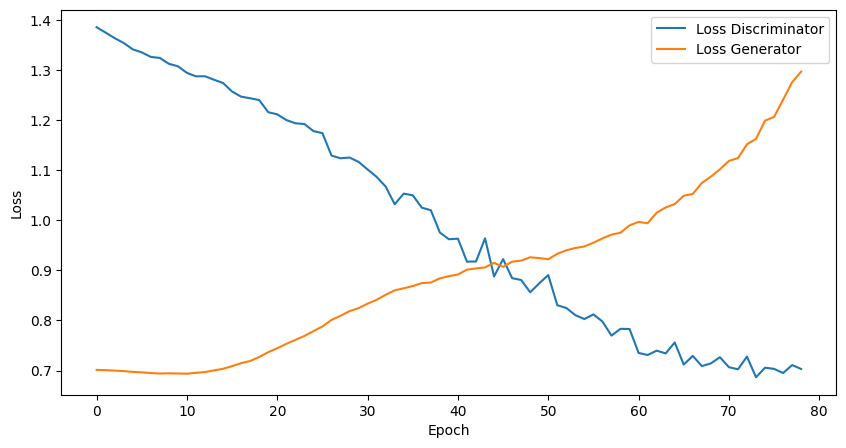

Epoch [2/20] Batch 0/79 Loss D: 0.6653, loss G: 1.3653 D(x): 0.7729, D(G(z)): 0.3140 / 0.2559
Epoch [2/20] Batch 50/79 Loss D: 0.7027, loss G: 1.9206 D(x): 0.6911, D(G(z)): 0.2343 / 0.1475


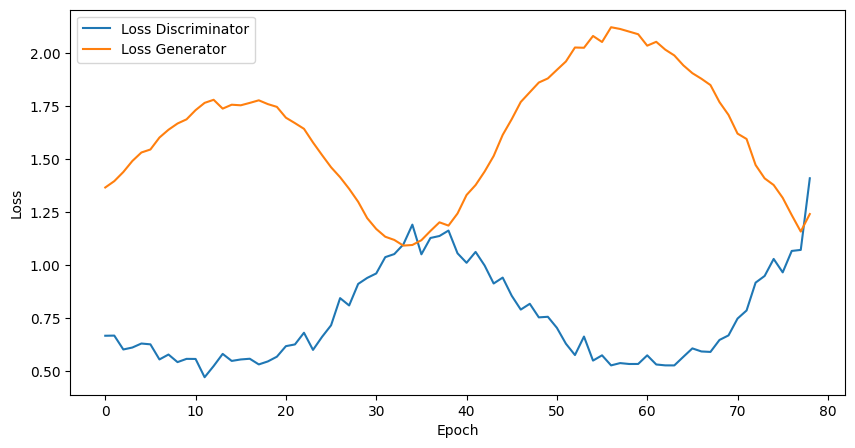

Epoch [3/20] Batch 0/79 Loss D: 1.1791, loss G: 1.1037 D(x): 0.7062, D(G(z)): 0.5177 / 0.3401
Epoch [3/20] Batch 50/79 Loss D: 0.9942, loss G: 1.6842 D(x): 0.5884, D(G(z)): 0.3047 / 0.1870


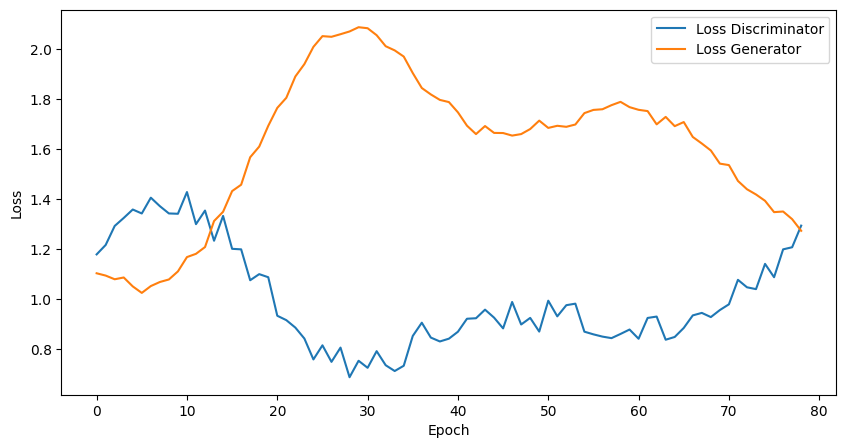

Epoch [4/20] Batch 0/79 Loss D: 1.2330, loss G: 1.2776 D(x): 0.5503, D(G(z)): 0.4017 / 0.2806
Epoch [4/20] Batch 50/79 Loss D: 1.1076, loss G: 0.9495 D(x): 0.7124, D(G(z)): 0.5148 / 0.3900


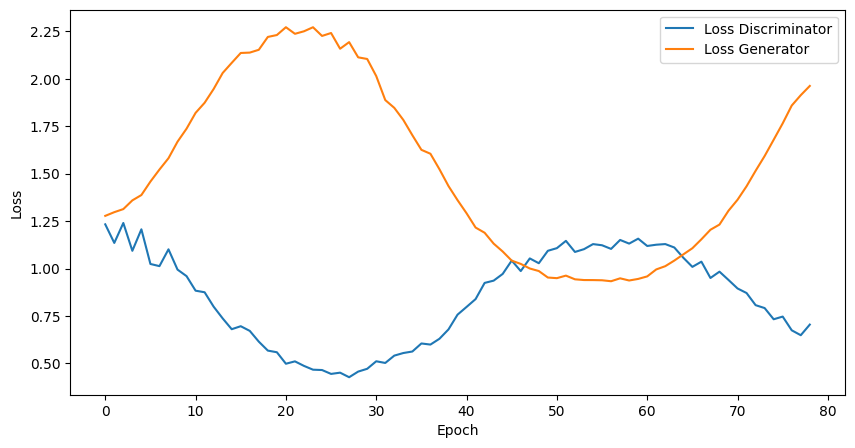

Epoch [5/20] Batch 0/79 Loss D: 0.6162, loss G: 1.9860 D(x): 0.7099, D(G(z)): 0.2054 / 0.1391
Epoch [5/20] Batch 50/79 Loss D: 0.6124, loss G: 1.6737 D(x): 0.7393, D(G(z)): 0.2420 / 0.1893


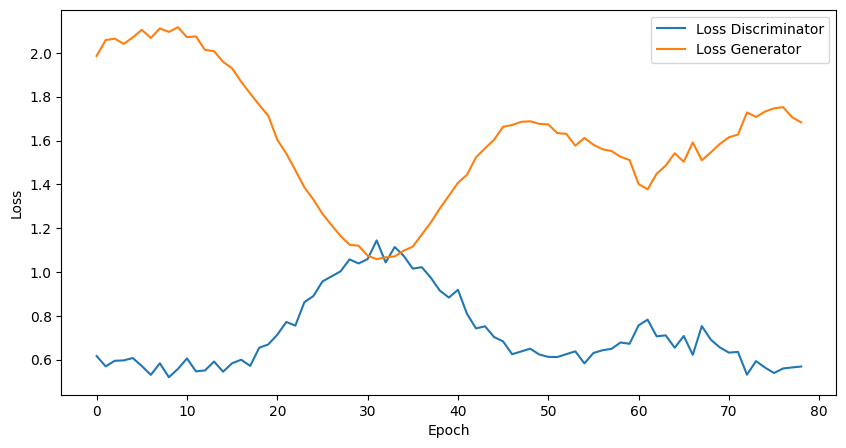

Epoch [6/20] Batch 0/79 Loss D: 0.5739, loss G: 1.6971 D(x): 0.7895, D(G(z)): 0.2334 / 0.1843
Epoch [6/20] Batch 50/79 Loss D: 0.9884, loss G: 1.5615 D(x): 0.7575, D(G(z)): 0.3289 / 0.2112


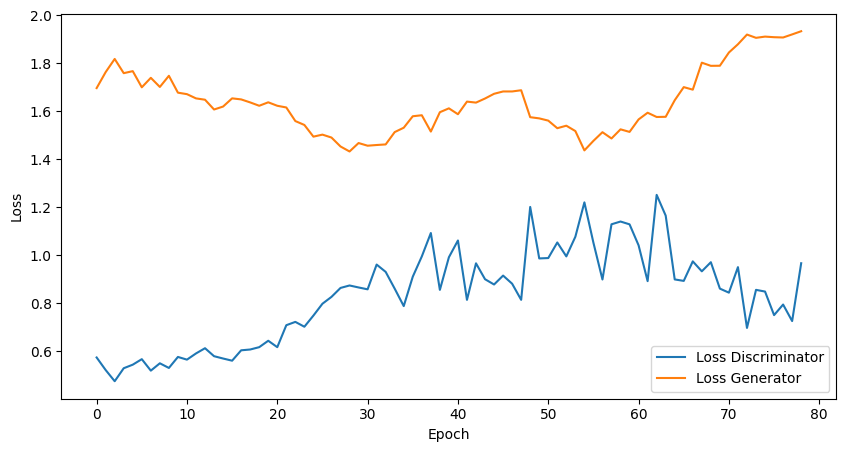

Epoch [7/20] Batch 0/79 Loss D: 0.6381, loss G: 1.8861 D(x): 0.8287, D(G(z)): 0.2779 / 0.1550
Epoch [7/20] Batch 50/79 Loss D: 0.9324, loss G: 2.1791 D(x): 0.7182, D(G(z)): 0.2325 / 0.1151


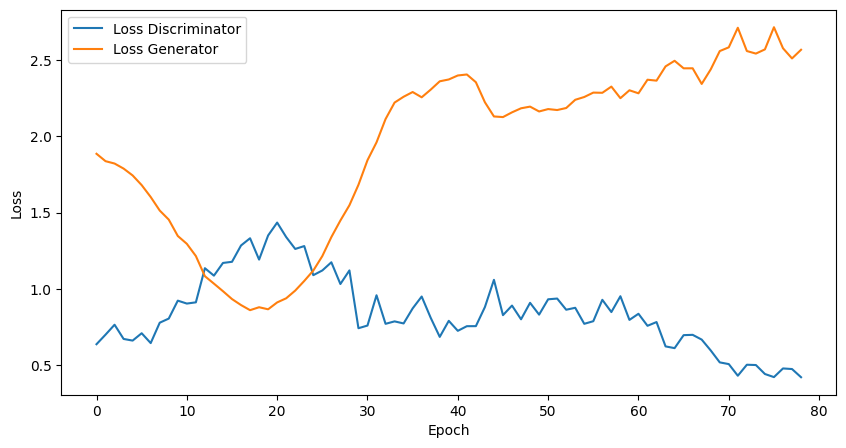

Epoch [8/20] Batch 0/79 Loss D: 0.5156, loss G: 2.3728 D(x): 0.7550, D(G(z)): 0.1838 / 0.1017
Epoch [8/20] Batch 50/79 Loss D: 0.2902, loss G: 2.8241 D(x): 0.8605, D(G(z)): 0.1215 / 0.0631


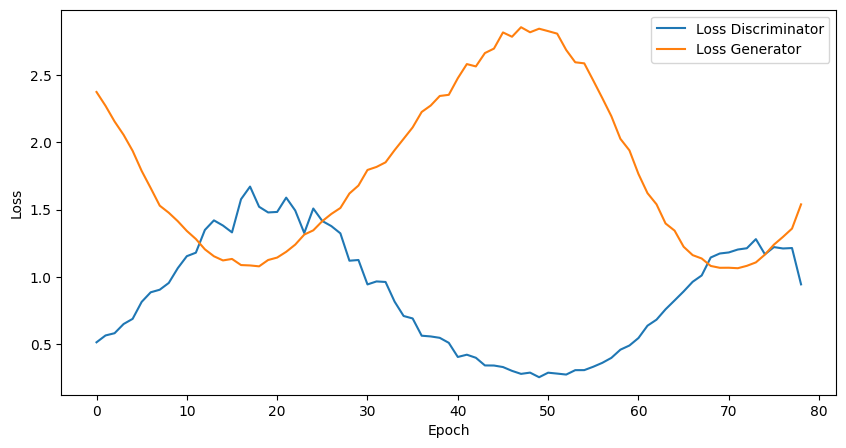

Epoch [9/20] Batch 0/79 Loss D: 0.9618, loss G: 1.6398 D(x): 0.6684, D(G(z)): 0.3490 / 0.1967
Epoch [9/20] Batch 50/79 Loss D: 0.9309, loss G: 1.5582 D(x): 0.6292, D(G(z)): 0.3151 / 0.2139


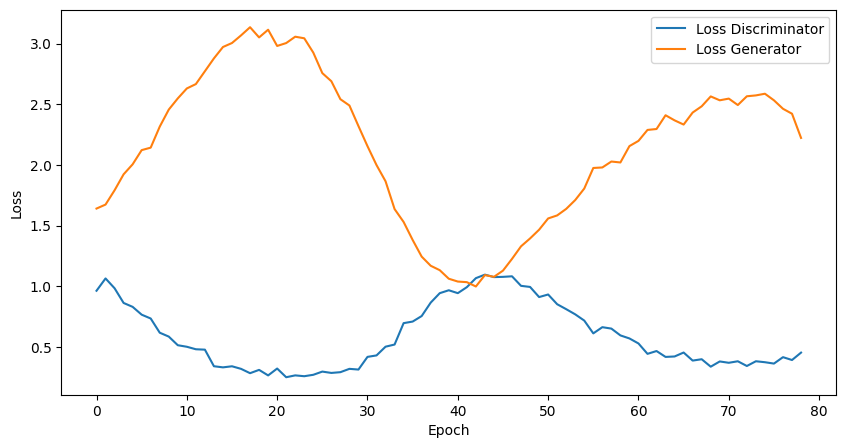

Epoch [10/20] Batch 0/79 Loss D: 0.3917, loss G: 2.3704 D(x): 0.8510, D(G(z)): 0.1828 / 0.0953
Epoch [10/20] Batch 50/79 Loss D: 0.3859, loss G: 2.6960 D(x): 0.8444, D(G(z)): 0.1669 / 0.0690


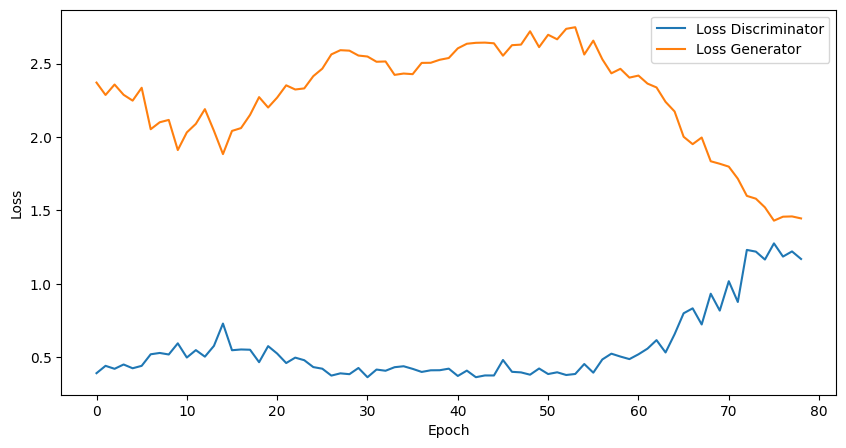

Epoch [11/20] Batch 0/79 Loss D: 1.0797, loss G: 1.4343 D(x): 0.7695, D(G(z)): 0.4697 / 0.2487
Epoch [11/20] Batch 50/79 Loss D: 0.6496, loss G: 2.3292 D(x): 0.8280, D(G(z)): 0.2246 / 0.1029


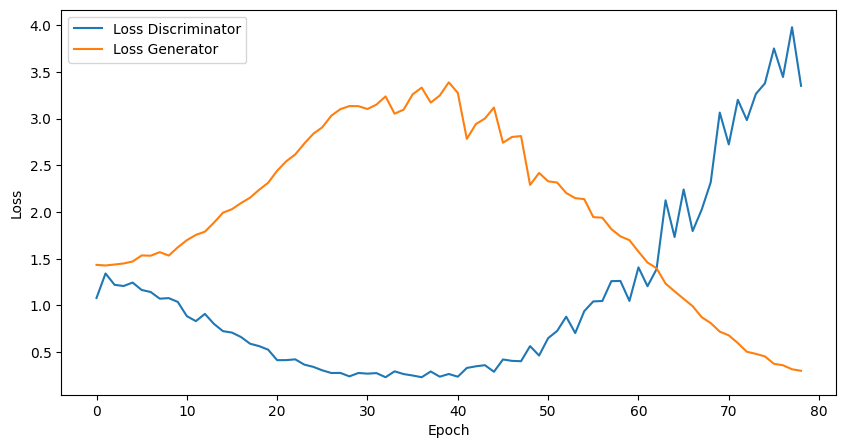

Epoch [12/20] Batch 0/79 Loss D: 3.7040, loss G: 0.3265 D(x): 0.6198, D(G(z)): 0.8536 / 0.7266
Epoch [12/20] Batch 50/79 Loss D: 0.4312, loss G: 2.7402 D(x): 0.8074, D(G(z)): 0.0869 / 0.0689


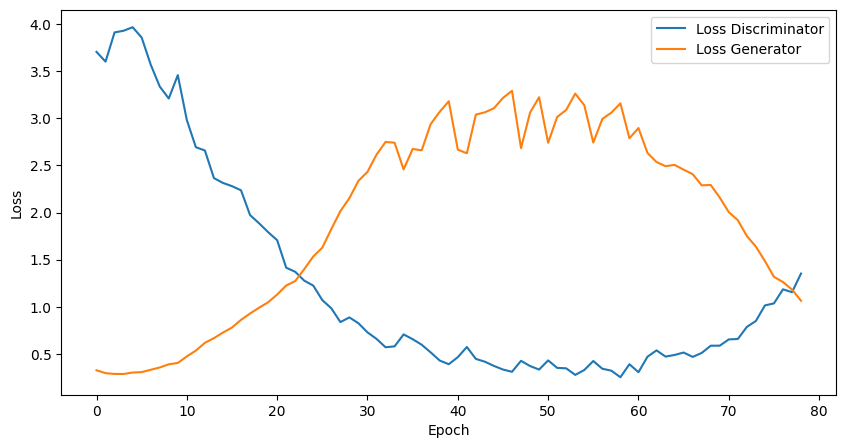

Epoch [13/20] Batch 0/79 Loss D: 1.2557, loss G: 1.0464 D(x): 0.7964, D(G(z)): 0.5901 / 0.3584
Epoch [13/20] Batch 50/79 Loss D: 1.1911, loss G: 1.8788 D(x): 0.6448, D(G(z)): 0.2872 / 0.1573


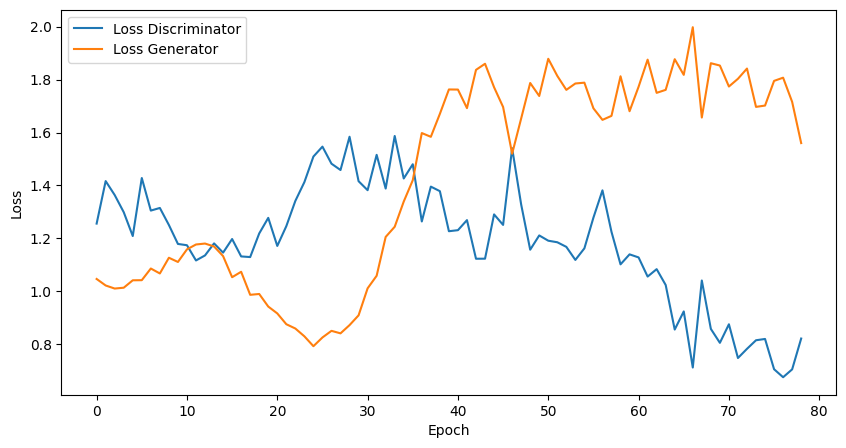

Epoch [14/20] Batch 0/79 Loss D: 0.6295, loss G: 1.7287 D(x): 0.8007, D(G(z)): 0.3026 / 0.1847
Epoch [14/20] Batch 50/79 Loss D: 0.5710, loss G: 1.8093 D(x): 0.8336, D(G(z)): 0.2827 / 0.1671


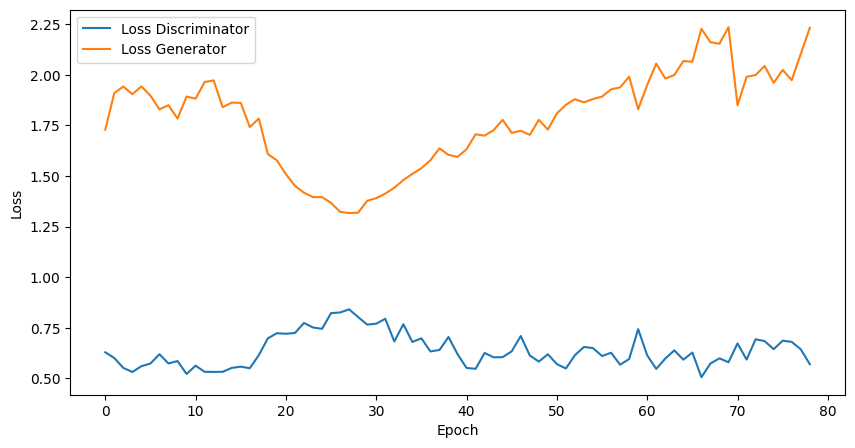

Epoch [15/20] Batch 0/79 Loss D: 0.5885, loss G: 1.9578 D(x): 0.7647, D(G(z)): 0.1737 / 0.1445
Epoch [15/20] Batch 50/79 Loss D: 0.3418, loss G: 2.7678 D(x): 0.8695, D(G(z)): 0.1460 / 0.0663


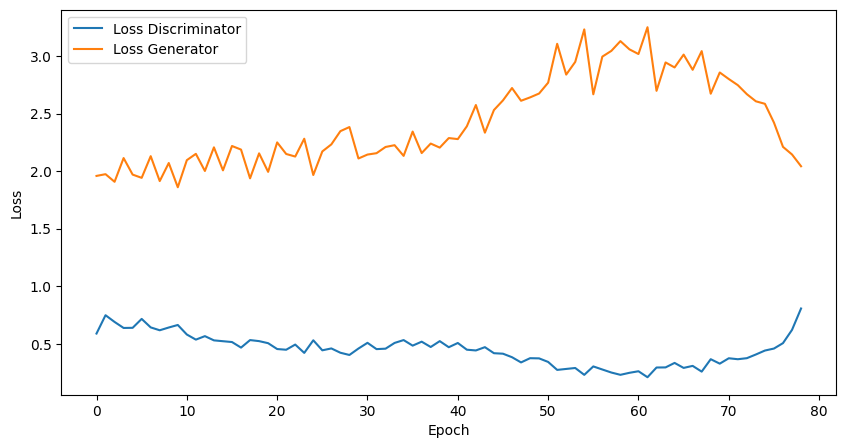

Epoch [16/20] Batch 0/79 Loss D: 0.8255, loss G: 1.7206 D(x): 0.8302, D(G(z)): 0.4035 / 0.1946


In [ ]:

for epoch in range(NUM_EPOCHS):
    loss_dis = []
    loss_girs = []
    """
      Alothgim:
      1. Train Discriminator
      2. Train Generator

    """

    for i, (real_data, real_labels_one_hot) in enumerate(dataloader):

        batch_size = real_data.size(0)
        real_data = real_data.to(device)
        real_labels_one_hot = real_labels_one_hot.to(device)

        # Tạo nhãn thật và giả
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ========================
        #  Train Discriminator
        # ========================

        # Đánh giá dữ liệu thật với nhãn thật
        D_x, d_loss_real = disriminator_train_loop(real_data, real_labels_one_hot)

        # Tạo dữ liệu giả
        fake_data, random_labels_one_hot = generate_fake_data(batch_size)

        # Đánh giá dữ liệu giả với nhãn giả
        D_G_z1, d_loss_fake = eval_discriminator_with_fake_data(fake_data.detach(), random_labels_one_hot)
        d_loss = d_loss_real + d_loss_fake

        # Cập nhật trọng số của Discriminator
        optimizerD = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
        optimizerD.step()

        # ========================
        #  Train Generator
        # ========================


        # Tạo dữ liệu giả mới
        fake_data, random_labels_one_hot = generate_fake_data(batch_size)

        # Đánh giá dữ liệu giả với nhãn thật (muốn đánh lừa Discriminator)
        D_G_z2, g_loss = eval_discriminator_with_real_data(fake_data, random_labels_one_hot, real_labels)

        # Cập nhật trọng số của Generator
        optimizerG = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
        optimizerG.step()

        loss_dis.append(d_loss.item())
        loss_girs.append(g_loss.item())
        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Batch {i}/{len(dataloader)} Loss D: {d_loss.item():.4f}, loss G: {g_loss.item():.4f} D(x): {D_x:.4f}, D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}")
    plt.figure(figsize=(10, 5))
    plt.plot(loss_dis, label='Loss Discriminator')
    plt.plot(loss_girs, label='Loss Generator')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    plt.close()

In [ ]:


# Giả định dữ liệu là 21 điểm của bàn tay (42 tọa độ)
num_landmarks = 42 // 2

# Định nghĩa các kết nối giữa các điểm để vẽ đường nối
# Dựa trên cấu trúc bàn tay của MediaPipe Hand Landmarks
connections = [
    (0, 1), (1, 2), (2, 3), (3, 4),      # Ngón cái
    (0, 5), (5, 6), (6, 7), (7, 8),      # Ngón trỏ
    (5, 9), (9, 10), (10, 11), (11, 12), # Ngón giữa
    (9, 13), (13, 14), (14, 15), (15, 16), # Ngón áp út
    (13, 17), (17, 18), (18, 19), (19, 20), # Ngón út
    (0, 17) # Nối ngón cái và ngón út
]

# Tạo một figure và các subplot để hiển thị 5 mẫu
fig, axes = plt.subplots(1, num_samples_per_label*NUM_CLASSES, figsize=(15, 5))
fig.suptitle('Mẫu dữ liệu tọa độ MediaPipe được tạo bởi GAN', fontsize=16)
for key, value in fake_data_with_labels.items():
    x_coords = value[:, 0::2]  # Tọa độ x
    y_coords = value[:, 1::2]  # Tọa độ y
    item = value[0]
    print(x_coords.shape, y_coords.shape)

    for i in range(num_samples_per_label):
        ax = axes[i]

        # Vẽ các điểm mốc (landmarks)
        ax.scatter(x_coords[i], y_coords[i], color='blue', s=20, zorder=5)

        # Vẽ các đường nối giữa các điểm
        for start, end in connections:
            ax.plot([x_coords[i][start], x_coords[i][end]],
                    [y_coords[i][start], y_coords[i][end]],
                    color='green', linewidth=2, zorder=1)

        # Đặt giới hạn cho trục để hình ảnh không bị méo
        # Matplotlib có thể tự động điều chỉnh giới hạn, nhưng việc đặt thủ công giúp các subplot đồng nhất
        ax.set_xlim(dataset.coordinates_min[0::2].min(), dataset.coordinates_max[0::2].max())
        ax.set_ylim(dataset.coordinates_min[1::2].min(), dataset.coordinates_max[1::2].max())

        # Đảo ngược trục y để gốc tọa độ ở trên cùng, giống với hình ảnh thông thường
        ax.invert_yaxis()
        ax.set_title(f'Mẫu {i+1} - Nhãn: {item[0]}')
        ax.set_aspect('equal', adjustable='box')
        plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# for i in range(num_samples_per_label):
#     # Trích xuất tọa độ x, y cho mẫu thứ i
#     x_coords = data[i][i, 0::2]
#     y_coords = data[i][i, 1::2]
#     print (x_coords)
#     print("/")
#     print (y_coords)

#     ax = axes[i]

#     # Vẽ các điểm mốc (landmarks)
#     ax.scatter(x_coords, y_coords, color='blue', s=20, zorder=5)

#     # Vẽ các đường nối giữa các điểm
#     for start, end in connections:
#         ax.plot([x_coords[start], x_coords[end]],
#                 [y_coords[start], y_coords[end]],
#                 color='green', linewidth=2, zorder=1)

#     # Đặt giới hạn cho trục để hình ảnh không bị méo
#     # Matplotlib có thể tự động điều chỉnh giới hạn, nhưng việc đặt thủ công giúp các subplot đồng nhất
#     ax.set_xlim(dataset.coordinates_min[0::2].min(), dataset.coordinates_max[0::2].max())
#     ax.set_ylim(dataset.coordinates_min[1::2].min(), dataset.coordinates_max[1::2].max())

#     # Đảo ngược trục y để gốc tọa độ ở trên cùng, giống với hình ảnh thông thường
#     ax.invert_yaxis()
#     ax.set_title(f'Mẫu {i+1}')
#     ax.set_aspect('equal', adjustable='box') # Đảm bảo tỷ lệ x/y đồng nhất

# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()